In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import networkx as nx

# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Import momepy - if a custom path exists, use it; otherwise use the installed version
momepy_path = Path(os.path.expanduser("~/Projects/momepy-yuta"))
if momepy_path.exists():
    sys.path.insert(0, str(momepy_path))
    import momepy
    print(f"momepy imported from custom path: {momepy_path}")
else:
    import momepy
    print("Using installed momepy package")

# Import city2graph package
city2graph_path = Path(os.path.expanduser("~/Projects/city2graph"))
if city2graph_path.exists():
    sys.path.insert(0, str(city2graph_path))
    import city2graph
    print(f"city2graph imported from: {city2graph_path}")
    print(f"city2graph version: {city2graph.__version__ if hasattr(city2graph, '__version__') else 'dev'}")

momepy imported from custom path: /Users/yutasato/Projects/momepy-yuta
city2graph imported from: /Users/yutasato/Projects/city2graph
city2graph version: dev


# GTFS Data Processing Functions

The General Transit Feed Specification (GTFS) is a standard format for public transportation schedules and associated geographic information. Below are functions to load and process GTFS data from a zip file.

In [107]:
sample_gtfs_path = Path("itm_london_gtfs.zip")
gtfs_data = city2graph.load_gtfs(sample_gtfs_path)

INFO:city2graph.transportation_network:Loading GTFS data from itm_london_gtfs.zip...
INFO:city2graph.transportation_network:Loaded 10 GTFS files
INFO:city2graph.transportation_network:Processing GTFS DataFrames...
INFO:city2graph.transportation_network:Creating stops geometry...
INFO:city2graph.transportation_network:Creating shapes geometry...
INFO:city2graph.transportation_network:GTFS data processing complete


In [109]:
# Calculate average travel times and frequencies with optional time filtering.
# For example, to filter segments starting after '06:00:00' and ending before '10:00:00':
travel_summary_gdf = city2graph.create_travel_summary_network(gtfs_data, calendar_start="20250401", calendar_end="20250401", as_gdf=True)

In [ ]:
import folium

# Filter to get only segments with frequency = 1
low_frequency_segments = travel_summary_gdf[travel_summary_gdf["travel_time"] < 300]

# Create a base map centered on the average coordinates of these segments
# Extract the coordinates from each LineString geometry
segment_coordinates = []
for geom in low_frequency_segments.geometry:
    if isinstance(geom, LineString):
        first_point = geom.coords[0]
        segment_coordinates.append((first_point[1], first_point[0]))  # Folium expects lat,lon

if segment_coordinates:
    avg_lat = sum(coord[0] for coord in segment_coordinates) / len(segment_coordinates)
    avg_lon = sum(coord[1] for coord in segment_coordinates) / len(segment_coordinates)
else:
    # Fallback to default coordinates
    avg_lat, avg_lon = 51.5074, -0.1278

# Create a map
m_low_freq = folium.Map(location=[avg_lat, avg_lon], zoom_start=7)

# Add each segment to the map
for idx, row in low_frequency_segments.iterrows():
    line_coords = []
    for x, y in row.geometry.coords:
        line_coords.append([y, x])  # Folium expects [lat, lon]
    
    # Add the line to the map with tooltip showing travel time
    folium.PolyLine(
        line_coords,
        color='red',
        weight=3,
        opacity=1,
        tooltip=f"From: {row['from_stop_id']} To: {row['to_stop_id']}<br>Travel Time: {row['travel_time']} seconds"
    ).add_to(m_low_freq)

# Add stops from gtfs_data['stops'] as nodes on the map
for _, stop in gtfs_data['stops'].iterrows():
    folium.CircleMarker(
        location=[stop['stop_lat'], stop['stop_lon']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        popup=stop['stop_name']
    ).add_to(m_low_freq)

# Display the map with stops added
m_low_freq

<Axes: >

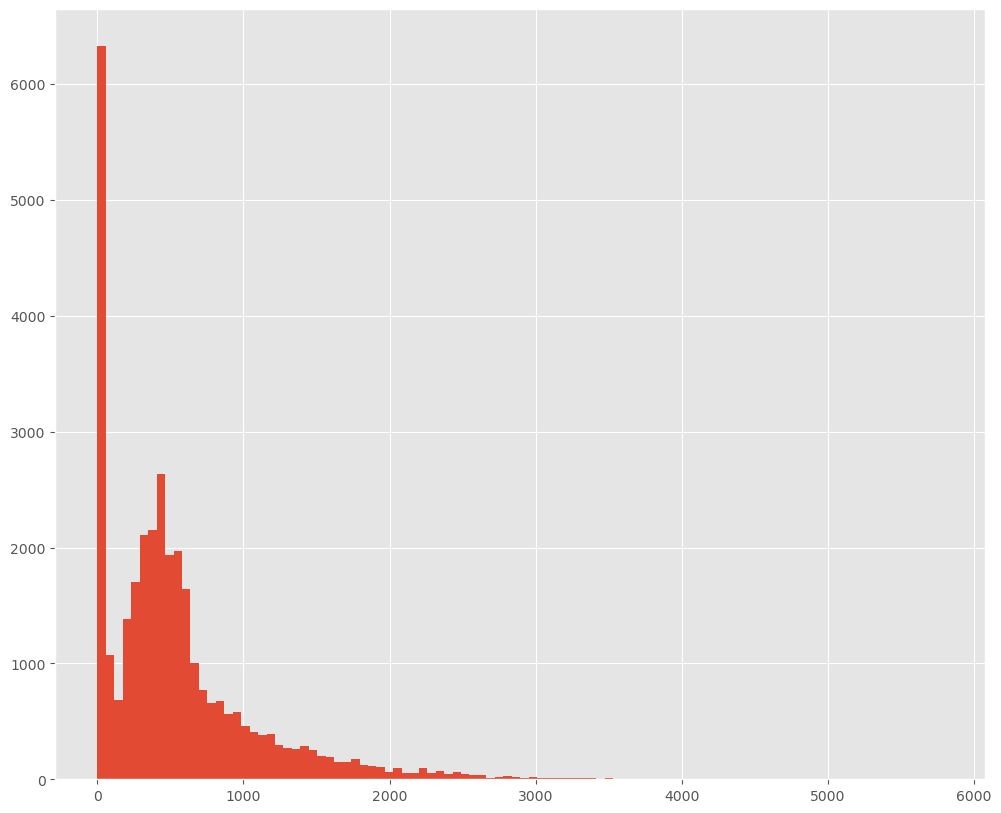

In [115]:
travel_summary_gdf["frequency"].hist(bins=100)

In [ ]:
import folium

# Create a map centered around the average latitude and longitude of the stops
def create_map(gtfs_data):
    # Calculate the average latitude and longitude of the stops
    avg_lat = gtfs_data['stops']['stop_lat'].mean()
    avg_lon = gtfs_data['stops']['stop_lon'].mean()

    # Create a folium map centered at the average coordinates
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

    # Add all stops to the map
    for _, stop in gtfs_data['stops'].iterrows():
        folium.Circle(
            location=[stop['stop_lat'], stop['stop_lon']],
            popup=stop['stop_name']
        ).add_to(m)

    return m

# Create the map
m = create_map(gtfs_data)

In [ ]:
od_gdf = city2graph.get_od_pairs(gtfs_data, start_date="20250401", end_date="20250401", include_geometry=True, as_generator=False)

In [ ]:
# To iterate over chunks and process/write them immediately
for od_chunk in city2graph.get_od_pairs(gtfs_data, as_generator=True, chunk_size=5000):
    # Process or write the chunk to disk
    print(od_chunk.shape)
    # Optionally, write to a file in append mode:
    od_chunk.to_csv('gtfs_od_pairs_chunk.csv', mode='a', header=not os.path.exists('gtfs_od_pairs_chunk.csv'), index=False)